# CEO-REQUEST CHALLENGE

> Should Olist remove underperforming sellers from its marketplace?

## Problem statement

To analyse the impact of removing the worse sellers from the marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the past ? For that:

Step ① Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step ② We can then sort sellers by increasing profits for Olist, and for each number of seller to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of seller to remove that maximizes Olist's profit margin

In [6]:
# Write down a detailed strategy (steps by step) to create the DataFrame you need for step (1)
# Think about how to re-use or updated what logic you have already coded in your `olist` package

Create a seller DF with the 4 features requested
1. Compute revenues: -> create a series
    composed of:
        cut of 10% of price (or total payment?) -> yes, exludes freight -> alreadt a series
        80 BRL/m/seller -> compute # of month between first and last -> create a series.
2. Costs: composed of:
    star penality -> do a complex aggregate with tailored function
    IT : NOT INCLUDED HERE!
3. Profits : easy substraction
4. Number of orders : already available

<details>
    <summary>Hints</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate in your source code in `seller.py` how was computed the mean `review_score` per seller. Can you imagine a way to ammend your code so as to compute `cost_of_reviews` in the same process ? 
</details>


## Your turn - step 1

### Sellers revenue

In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [8]:
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller

In [16]:
sellers = Seller().get_training_data()

In [320]:
sellers.groupby("seller_state").count()

,seller_id,seller_city,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales
seller_state,,,,,,,,,,,,
AM,1,1,1,1,1,1,1,1,1,1,1,1
BA,18,18,18,18,18,18,18,18,18,18,18,18
CE,12,12,12,12,12,12,12,12,12,12,12,12
DF,30,30,30,30,30,30,30,30,30,30,30,30
ES,22,22,22,22,22,22,22,22,22,22,22,22
GO,39,39,39,39,39,39,39,39,39,39,39,39
MA,1,1,1,1,1,1,1,1,1,1,1,1
MG,236,236,236,236,236,236,236,236,236,236,236,236
MS,5,5,5,5,5,5,5,5,5,5,5,5


In [60]:
seller_revenue = sellers[["seller_id", "sales", "date_first_sale", "date_last_sale"]].copy()

In [61]:
seller_revenue.loc[:, "sales_cut"] = seller_revenue["sales"] * 0.1

In [62]:
seller_revenue.loc[:, "months_active"] = \
    (seller_revenue["date_last_sale"] - seller_revenue["date_first_sale"])/np.timedelta64(365,'D')*12

In [63]:
seller_revenue["rounder_active"] = seller_revenue["months_active"].apply(lambda x : int(x)+1 if x>0 else 1)

In [64]:
seller_revenue.loc[:,"revenue"] = seller_revenue["sales_cut"] + 80 * seller_revenue["rounder_active"]

In [129]:
seller_revenue

,seller_id,sales,date_first_sale,date_last_sale,sales_cut,months_active,rounder_active,revenue
0,3442f8959a84dea7ee197c632cb2df15,218.70,2017-05-05 16:25:11,2017-08-30 12:50:19,21.870,3.841670,4,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,11703.07,2017-03-29 02:10:34,2018-06-06 20:15:21,1170.307,14.293260,15,2370.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,158.00,2018-07-30 12:44:49,2018-07-30 12:44:49,15.800,0.000000,1,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,79.99,2018-08-03 00:44:08,2018-08-03 00:44:08,7.999,0.000000,1,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,167.99,2017-11-14 12:15:25,2017-11-14 12:15:25,16.799,0.000000,1,96.799
...,...,...,...,...,...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,158.00,2018-07-14 03:10:19,2018-07-23 15:34:03,15.800,0.312871,1,95.800
2966,f8201cab383e484733266d1906e2fdfa,889.00,2017-06-17 15:30:11,2018-08-11 19:55:17,88.900,13.814272,14,1208.900
2967,74871d19219c7d518d0090283e03c137,550.04,2018-04-05 17:09:46,2018-08-21 19:25:15,55.004,4.540080,5,455.004
2968,e603cf3fec55f8697c9059638d6c8eb5,297.00,2017-02-09 02:43:17,2017-06-16 17:30:16,29.700,4.195593,5,429.700


### Seller's cost

In [125]:
matching_table = Olist().get_matching_table()

In [134]:
len(matching_table["seller_id"].unique())

3096

In [170]:
def cost(x):
    cost = 0
    for score in x:
        if score == 1:
            cost +=100
        if score == 2:
            cost += 50
        if score == 3:
            cost += 40
    return cost

In [171]:
orders_reviews = Order().get_review_score()
matching_table = matching_table[['order_id','seller_id']].drop_duplicates()
df = matching_table.merge(orders_reviews, on='order_id')

df = df.groupby('seller_id',as_index=False).agg({'dim_is_one_star': 'mean',\
                                             'dim_is_five_star': 'mean',\
                                             'review_score': ['mean', cost, 'count']
                                             })
df.columns = ['seller_id', 'share_one_stars',\
                      'share_of_five_stars', 'review_score', 'review_cost', 'review_count']

In [323]:
df = df.sort_values('review_cost')
df = df.merge(sellers, on = "seller_id")
df

,seller_id,share_one_stars_x,share_of_five_stars_x,review_score_x,review_cost,review_count,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_one_stars_y,share_of_five_stars_y,review_score_y,n_orders,quantity,sales
0,7d81e74a4755b552267cd5e081563028,0.000000,0.000000,4.000000,0,1,sao paulo,SP,0.0,2.209491,2018-08-20 15:50:21,2018-08-20 15:50:21,0.000000,0.000000,4.000000,1,1,32.50
1,e503f22be6a4f456d9851920a5d9c670,0.000000,0.000000,4.000000,0,2,sao paulo,SP,0.0,5.669965,2018-07-30 12:44:51,2018-08-14 15:25:24,0.000000,0.000000,4.000000,2,2,198.90
2,a080fc8a850289b27500f6b49cca2553,0.000000,0.750000,4.750000,0,4,sao paulo,SP,0.0,5.423171,2018-03-13 21:08:04,2018-06-25 19:15:23,0.000000,0.750000,4.750000,4,4,383.00
3,447d377bdb757058acb569025ee18a93,0.000000,1.000000,5.000000,0,1,carazinho,RS,0.0,18.004062,2018-02-02 19:41:59,2018-02-02 19:41:59,0.000000,1.000000,5.000000,1,1,64.99
4,44ed138eca6214d572ce1d813fb0049b,0.000000,0.500000,4.500000,0,2,canoas,RS,0.0,8.585093,2018-08-08 01:05:13,2018-08-21 09:55:13,0.000000,0.500000,4.500000,2,3,129.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,1f50f920176fa81dab994f9023523100,0.113556,0.598297,4.123492,22270,1409,sao jose do rio preto,SP,0.0,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,0.113556,0.598297,4.123492,1404,1940,106939.21
2966,7c67e1448b00f6e969d365cea6b010ab,0.200405,0.350202,3.484818,28530,988,itaquaquecetuba,SP,0.0,22.392546,2017-01-26 22:55:10,2018-08-08 03:10:34,0.200405,0.350202,3.484818,982,1375,187923.89
2967,cc419e0650a3c5ba77189a1882b7556a,0.117277,0.581808,4.069222,30000,1748,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,0.117277,0.581808,4.069222,1706,1819,104288.42
2968,6560211a19b47992c3666cc44a7e94c0,0.127957,0.510215,3.922043,36270,1860,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,0.127957,0.510215,3.922043,1854,2039,123304.83


### Profit per seller

In [173]:
seller_stat = seller_revenue.merge(df, on = 'seller_id')[["seller_id", "revenue", "review_cost"]]

In [174]:
seller_stat.loc[:, "seller_profit"] = seller_stat["revenue"] - seller_stat["review_cost"]

In [175]:
seller_stat['seller_profit'].sort_values()

769    -22419.517
2360   -19242.708
1358   -18051.158
946    -15952.248
315    -13066.431
          ...    
9        6780.462
2153     7288.455
534     14254.203
67      14603.187
868     17967.605
Name: seller_profit, Length: 2970, dtype: float64

### Total seller stat table

In [176]:
seller_stat = seller_stat.merge(sellers, on = 'seller_id')[["seller_id", "seller_profit", "n_orders"]]

In [177]:
seller_stat

,seller_id,seller_profit,n_orders
0,3442f8959a84dea7ee197c632cb2df15,201.870,3
1,d1b65fc7debc3361ea86b5f14c68d2e2,2130.307,40
2,ce3ad9de960102d0677a81f5d0bb7b2d,95.800,1
3,c0f3eea2e14555b6faeea3dd58c1b1c3,87.999,1
4,51a04a8a6bdcb23deccc82b0b80742cf,-3.201,1
...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,95.800,2
2966,f8201cab383e484733266d1906e2fdfa,1068.900,10
2967,74871d19219c7d518d0090283e03c137,455.004,6
2968,e603cf3fec55f8697c9059638d6c8eb5,379.700,8


### IT costs per seller

In [213]:
seller_stat = seller_stat.sort_values(by = 'seller_profit')
seller_stat

,seller_id,seller_profit,n_orders,it_cost
769,6560211a19b47992c3666cc44a7e94c0,-22419.517,1854,1806.997275
2360,4a3ca9315b744ce9f8e9374361493884,-19242.708,1806,1783.452331
1358,cc419e0650a3c5ba77189a1882b7556a,-18051.158,1706,1733.373474
946,ea8482cd71df3c1969d7b9473ff13abc,-15952.248,1146,1420.675665
315,8b321bb669392f5163d04c59e235e066,-13066.431,943,1288.719735
...,...,...,...,...
9,ccc4bbb5f32a6ab2b7066a4130f114e3,6780.462,187,573.883100
2153,edb1ef5e36e0c8cd84eb3c9b003e486d,7288.455,166,540.700382
534,fa1c13f2614d7b5c4749cbc52fecda94,14254.203,585,1015.033944
67,7e93a43ef30c4f03f38b393420bc753a,14603.187,336,769.258443


In [207]:
tmp = seller_stat["n_orders"].apply(lambda X:X**0.5)
tmp.sum()

11914.26818459575

In [208]:
N_orders = matching_table["order_id"].nunique()
cst = 500000/(seller_stat["n_orders"].apply(lambda X:X**0.5).sum())
cst

41.96648860451725

In [190]:
# def IT_costs(x):
#     cst = 500000/N_orders**0.5
#     return cst * x**0.5
# def IT_savings(x):
#     return 500000 - IT_costs(N_orders - x)

In [209]:
def IT_costs(x):
    return cst * x**0.5

In [210]:
seller_stat.loc[:, "it_cost"] = seller_stat["n_orders"].map(IT_costs)

In [215]:
seller_stat.loc[:, "final_profit"] = seller_stat["seller_profit"] - seller_stat["it_cost"]
seller_stat.sort_values(by = 'final_profit')

,seller_id,seller_profit,n_orders,it_cost,final_profit
769,6560211a19b47992c3666cc44a7e94c0,-22419.517,1854,1806.997275,-24226.514275
2360,4a3ca9315b744ce9f8e9374361493884,-19242.708,1806,1783.452331,-21026.160331
1358,cc419e0650a3c5ba77189a1882b7556a,-18051.158,1706,1733.373474,-19784.531474
946,ea8482cd71df3c1969d7b9473ff13abc,-15952.248,1146,1420.675665,-17372.923665
315,8b321bb669392f5163d04c59e235e066,-13066.431,943,1288.719735,-14355.150735
...,...,...,...,...,...
9,ccc4bbb5f32a6ab2b7066a4130f114e3,6780.462,187,573.883100,6206.578900
2153,edb1ef5e36e0c8cd84eb3c9b003e486d,7288.455,166,540.700382,6747.754618
534,fa1c13f2614d7b5c4749cbc52fecda94,14254.203,585,1015.033944,13239.169056
67,7e93a43ef30c4f03f38b393420bc753a,14603.187,336,769.258443,13833.928557


## Your turn - step 2 (sorting through sellers)

function that computes profit when removing n worst sellers, constant alpha (IT cost coef)

In [ ]:
seller_stat.loc[:, "cut "] = seller_stat["seller_profit"] - seller_stat["it_cost"]

In [226]:
def cut_losses(n):
    return seller_stat["final_profit"][n:].sum()

In [240]:
x = np.linspace(0, 1000, 100)
# y = [cut_losses(i) for i in x]
y =[cut_losses(int(i)) for i in x]

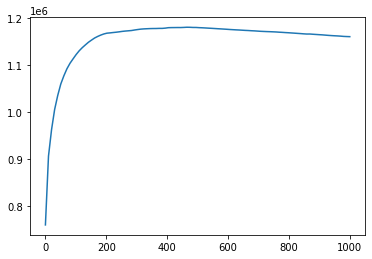

In [241]:
plt.plot(x , y)

In [251]:
cutting_losses = seller_stat[seller_stat["final_profit"] > 0]["final_profit"].sum() - seller_stat["final_profit"].sum()
cutting_losses

431486.86710598296

In [254]:
seller_stat.loc[:,"profit_per_order"] = seller_stat["final_profit"]/seller_stat["n_orders"]

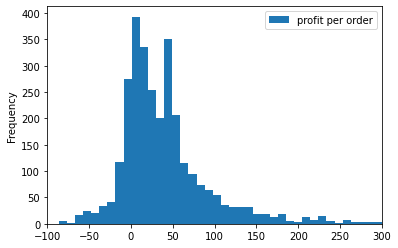

In [272]:
seller_stat["profit_per_order"].plot(kind = 'hist', label = 'profit per order', xlim = (-100,300), bins = 100)
plt.legend()

<AxesSubplot:xlabel='n_orders', ylabel='profit_per_order'>

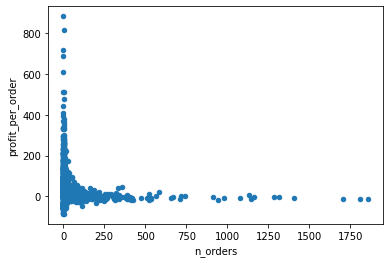

In [275]:
seller_stat.plot( x = 'n_orders', y='profit_per_order', kind = 'scatter')

In [287]:
total_seller = seller_stat.merge(seller_revenue, on = "seller_id")
total_seller.columns

Index(['seller_id', 'seller_profit', 'n_orders', 'it_cost', 'final_profit',
       'profit_per_order', 'sales', 'date_first_sale', 'date_last_sale',
       'sales_cut', 'months_active', 'rounder_active', 'revenue'],
      dtype='object')

<AxesSubplot:xlabel='months_active', ylabel='profit_per_order'>

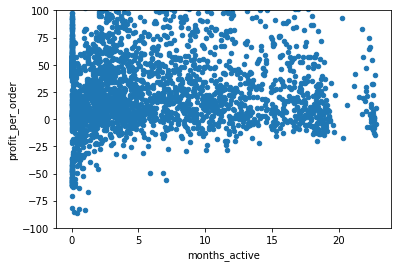

In [288]:
total_seller.plot( x = 'months_active', y='profit_per_order', kind = 'scatter', ylim = (-100,100))

<AxesSubplot:xlabel='months_active', ylabel='final_profit'>

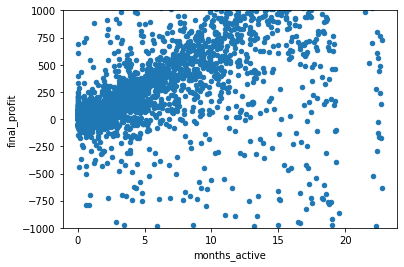

In [289]:
total_seller.plot( x = 'months_active', y='final_profit', kind = 'scatter', ylim = (-1000,1000))

In [291]:
tmp = seller_stat.merge(sellers, on = "seller_id")
tmp.columns

Index(['seller_id', 'seller_profit', 'n_orders_x', 'it_cost', 'final_profit',
       'profit_per_order', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'share_one_stars',
       'share_of_five_stars', 'review_score', 'n_orders_y', 'quantity',
       'sales'],
      dtype='object')

KeyboardInterrupt: 

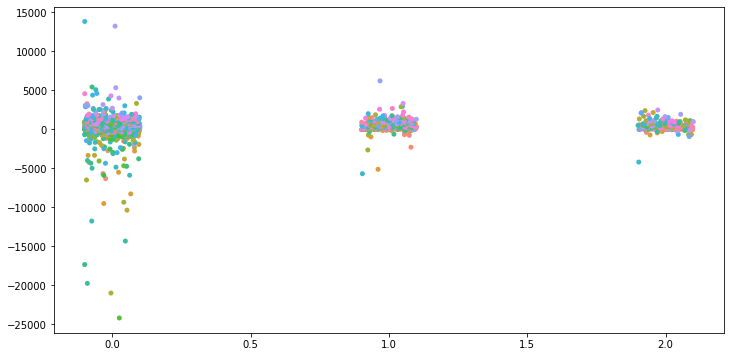

In [309]:
fig, ax1 = plt.subplots(1,1, figsize = (12,6))
sns.stripplot( x='seller_state', y = 'final_profit', hue = 'review_score', data = tmp, ax = ax1)

<AxesSubplot:xlabel='seller_state', ylabel='final_profit'>

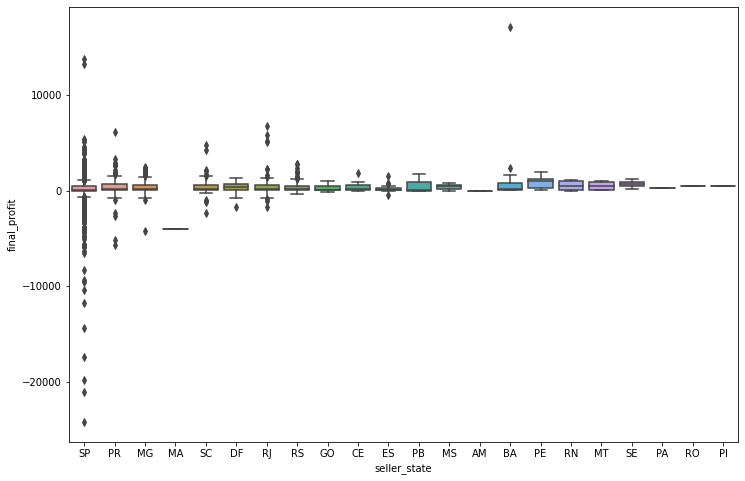

In [319]:
fig, ax1 = plt.subplots(1,1, figsize = (12,8))
sns.boxplot( x='seller_state', y = 'final_profit', data = tmp, ax = ax1)

<AxesSubplot:xlabel='review_score', ylabel='final_profit'>

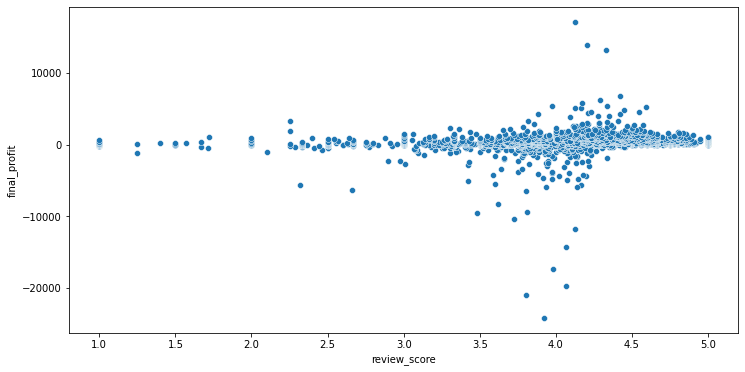

In [310]:
fig, ax1 = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( x='review_score', y = 'final_profit', data = tmp, ax = ax1)

In [318]:
total_seller.columns

Index(['seller_id', 'seller_profit', 'n_orders', 'it_cost', 'final_profit',
       'profit_per_order', 'sales', 'date_first_sale', 'date_last_sale',
       'sales_cut', 'months_active', 'rounder_active', 'revenue'],
      dtype='object')

[(-100.0, 100.0)]

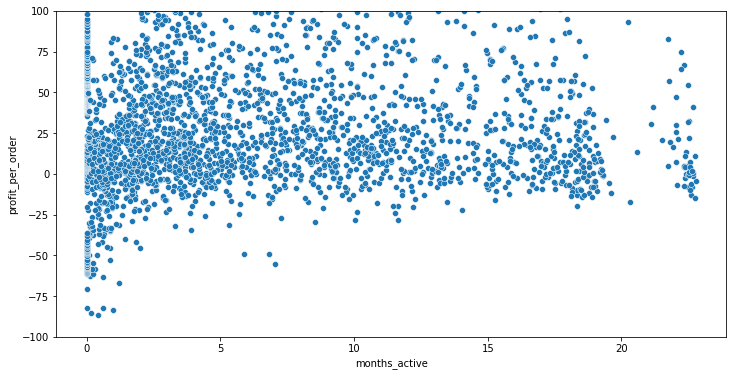

In [317]:
fig, ax1 = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( x='months_active', y = 'profit_per_order', data = total_seller, ax = ax1)
ax1.set(ylim =(-100, 100))